# Single Dummy Estimates

This tutorial shows the use of a neural network to estimate the number of tricks which will be taken on a given open lead in a given contract (single dummy)

In this tutorial we'll access a bit lower-level APIs.


In [1]:
import os
import sys
sys.path.append('../../src')

import numpy as np
import matplotlib.pyplot as plt

import scoring
import deck52

from nn.models import Models
from bidding import bidding
from bidding.binary import parse_hand_f
from bots import BotBid
from objects import Card
from util import hand_to_str
from sample import Sample
import conf

np.set_printoptions(precision=2, suppress=True, linewidth=200)
np.random.seed(42)


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
models = Models.from_conf(conf.load('../Conf/UCBC2024.conf'),'..')   # loading neural networks
sampler = Sample.from_conf(conf.load('../Conf/UCBC2024.conf'), False)  # Load sampling strategies


INFO:tensorflow:Restoring parameters from ..\Models/bidding-3233000
INFO:tensorflow:Restoring parameters from ..\Models/binfo-808000
INFO:tensorflow:Restoring parameters from ..\Models/lead-1000000
INFO:tensorflow:Restoring parameters from ..\Models/lead-1000000
INFO:tensorflow:Restoring parameters from ..\Models/lr3-1000000
INFO:tensorflow:Restoring parameters from ..\Models/lefty-1000000
INFO:tensorflow:Restoring parameters from ..\Models/dummy-920000
INFO:tensorflow:Restoring parameters from ..\Models/righty-1000000
INFO:tensorflow:Restoring parameters from ..\Models/decl-1000000


In [3]:
# helper functions are defined here. it's ok to scroll over this part

# this is the function which does the prediction
# for each possible number of tricks (from 0 to 13) 
# it returns the probability that that number of tricks will be taken (single dummy)
def single_dummy(model, hands, decl_i, strain_i, lead_card_i):
    # an array, which is the input for the neural network, is prepared
    X_sd = np.zeros((hands.shape[0], 32 + 5 + 4*32))
    X_sd[:,32 + strain_i] = 1
    X_sd[:,(32 + 5 + 0*32):(32 + 5 + 1*32)] = hands[:, (decl_i + 1) % 4]
    X_sd[:,(32 + 5 + 1*32):(32 + 5 + 2*32)] = hands[:, (decl_i + 2) % 4]
    X_sd[:,(32 + 5 + 2*32):(32 + 5 + 3*32)] = hands[:, (decl_i + 3) % 4]
    X_sd[:,(32 + 5 + 3*32):] = hands[:, decl_i]
    X_sd[:, lead_card_i] = 1
    
    return model(X_sd)

# plotting the trick probability distribution
def plot_tricks(tricks_softmax):
    tricks = tricks_softmax[0]
    plt.bar(range(14), tricks)
    plt.title(f'E(tricks) = {tricks @ np.arange(14)}')
    plt.xlabel('# tricks')
    plt.ylabel('probability')

def expected_score(tricks_softmax, contract, vuln):
    tricks = tricks_softmax
    score_by_tricks = np.array([scoring.score(contract, vuln, i) for i in range(14)])
    return tricks @ score_by_tricks

In [4]:
# we take the following hand as an example
# West plays it in 3N on a small heart lead
# how many tricks will declarer take?

hands_str = 'AQ8.KQ94.JT.KJ52 JT63.A8.K8532.T3 2.T753.A64.AQ876 K9754.J62.Q97.94'  # N E S W
contract = '4HN'
opening_lead = 'D2'

In [5]:
# this line just converts the string representation of the hands into a binary format
hands = np.vstack([parse_hand_f(32)(s) for s in hands_str.split()]).reshape((-1, 4, 32))

# applying the function which does the prediction
tricks_distr = single_dummy(
    models.sd_model.model, 
    hands, 
    decl_i='NESW'.index(contract[-1]), 
    strain_i='NSHDC'.index(contract[1]), 
    lead_card_i=deck52.card52to32(Card.from_symbol(opening_lead).code())
)

In [6]:
# the result is an array representing the probability distribution of tricks
# the first element of the array is the probability that declarer will take 0 tricks
# the last element of the array is the probability that declarer will take 13 tricks
tricks_distr

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.08, 0.21, 0.34, 0.26, 0.08]], dtype=float32)

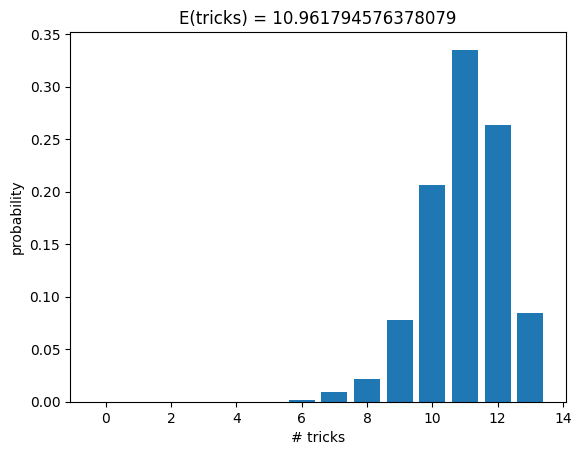

In [7]:
# we can also plot it to see it better
plot_tricks(tricks_distr)

We can see that the most likely declarer will take 10 tricks. But there is a spread, and declarer will take on average 9.57 tricks (according to the neural network)

In [8]:
# we can also compute how much declarer is expected to score on this hand (non-vulnerable)
expected_score(tricks_distr, contract='4H', vuln=False)[0]

399.4985700071088

In [9]:
# or we can get the probability that the contract will be made (i.e declarer will take 9 or more tricks)
np.sum(tricks_distr[:,10:])

0.8898591

## Estimating on many samples at the same time

A frequent use of single dummy models is to apply it on many samples to choose between possible actions (for example when making a bid or selecting the opening lead)

We could just follow the steps in the above example in a loop (looping once for each sample), but it's much more efficient to make the prediction for all samples at the same time:

In [10]:
# we'll use a bidder bot to draw samples which are consistent with the auction
# and give it North's cards (as North will be on lead against 3N)
bid_bot = BotBid([False, False], 'A8.Q752.T54.JT63', models, sampler, False)

# let's assume the following auction has occurred
auction = [
    'PASS', 'PASS', 'PASS', '1N', 
    'PASS', '2C', 'PASS', '2D', 
    'PASS', '3N', 'PASS', 'PASS', 
    'PASS', 'PAD_END', 'PAD_END', 'PAD_END'   # we need to put the 'PAD_END' stuff so it will look like it's North's turn to bid again
]
contract = bidding.get_contract(auction)

In [11]:
# we sample the hidden cards for the auction
samples, sorted_score, p_hcp, p_shp = bid_bot.sample_hands(auction)

# and display a few samples just for illustration
for i in range(10):
    print(f'{hand_to_str(samples[i,0,:])} {hand_to_str(samples[i,1,:])} {hand_to_str(samples[i,2,:])} {hand_to_str(samples[i,3,:])}')

A8.Qxxx.Txx.JTxx JT9x.KJ8.Q8x.Axx KQxx.Txx.9xx.Q9x xxx.A9x.AKJx.K8x
A8.Qxxx.Txx.JTxx xxxx.KT9.Qxx.AQx T9xx.Jxxx.A8x.9x KQJ.A8.KJ9x.K8xx
A8.Qxxx.Txx.JTxx QT9x.T9x.KJx.KQx xxxx.AK8x.9xx.9x KJx.Jx.AQ8x.A8xx
A8.Qxxx.Txx.JTxx JTxx.A9x.KQJ.9xx Qxxx.J8xx.9xx.K8 K9x.KT.A8xx.AQxx
A8.Qxxx.Txx.JTxx J9xx.8xx.AJx.KQx QTxx.K9x.Q98xx.x Kxx.AJT.Kx.A98xx
A8.Qxxx.Txx.JTxx QT9x.J9x.J9x.AK8 Jxxx.Txx.KQ8x.xx Kxx.AK8.Axx.Q9xx
A8.Qxxx.Txx.JTxx 9xxx.AJx.K8x.Qxx QTxx.Txx.Qxx.A9x KJx.K98.AJ9x.K8x
A8.Qxxx.Txx.JTxx Jxx.A98x.Qxx.Axx 9xxxx.Kx.xx.Q9xx KQT.JTx.AKJ98.K8
A8.Qxxx.Txx.JTxx Jxxx.T9x.Axx.AQx Q9xxx.Axx.Jx.9xx KT.KJ8.KQ98x.K8x
A8.Qxxx.Txx.JTxx Jxx.A98x.Kxx.K8x KT9xx.Txx.QJ8.9x Qxx.KJ.A9xx.AQxx


North's cards are always the same `A8.Qxxx.Txx.JTxx` (because it's the known hand)

The rest of the cards are consistent with the Stayman sequence which occurred in the auction (West has a 1N opener without four-card majors, East has a four-card major and the strength for 3N)

In [12]:
# now we apply the prediction on all samples (estimating how many tricks declarer will take in 3N)

# we consider the following opening leads
opening_lead_options = ['SA', 'H2', 'D4', 'CJ', 'C3']

In [13]:
# for each opening opening lead option,
# we estimate the number of tricks taken (on each sample)

lead_tricks = {}

for opening_lead in opening_lead_options:
    tricks_distr = single_dummy(
        models.sd_model.model, 
        samples, 
        decl_i='NESW'.index(contract[-1]), 
        strain_i='NSHDC'.index(contract[1]), 
        lead_card_i=deck52.card52to32(Card.from_symbol(opening_lead).code())
    )
    lead_tricks[opening_lead] = tricks_distr

In [14]:
# computing declarer's expected score for each lead

{lead:np.mean(expected_score(tricks, contract, False)) for lead, tricks in lead_tricks.items()}

{'SA': 280.53680909984865,
 'H2': 268.12243516857575,
 'D4': 245.88339311541225,
 'CJ': 258.54432703027413,
 'C3': 256.63302544005285}

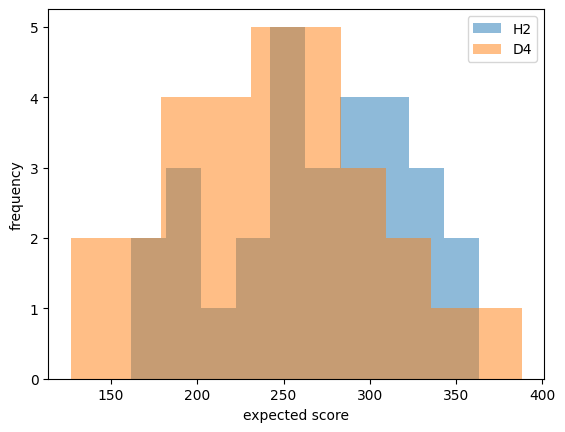

In [15]:
# to get an idea about the variance, we can compare two cards by plotting histograms of expected scores
plt.hist(expected_score(lead_tricks['H2'], contract, False), label='H2', alpha=0.5)
plt.hist(expected_score(lead_tricks['D4'], contract, False), label='D4', alpha=0.5)
plt.xlabel('expected score')
plt.ylabel('frequency')
plt.legend()